In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from diffusers import UNet2DModel, DDPMScheduler
import matplotlib.pyplot as plt
import os
import certifi
os.environ["SSL_CERT_FILE"] = certifi.where()

torch.manual_seed(42)

In [2]:
# -------------------- Hyperparameters --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
num_train_timesteps = 1000            # Total timesteps for the diffusion process
image_size = 32     # Image resolution (CIFAR images are 28x28)

# CIFAR-10 Dataset

CIFAR-10 is a widely used dataset in computer vision that consists of 60,000 color images, each with a resolution of 32×32 pixels, categorized into 10 distinct classes including airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset is split into 50,000 training images and 10,000 test images.

In [3]:
# -------------------- Dataset & Dataloader --------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),  # Converts images to PyTorch tensors and scales pixel values to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes each channel to [-1, 1]
])
# Set download=True if the dataset is not already available in the specified directory.
dataset = datasets.CIFAR10('.', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

Files already downloaded and verified


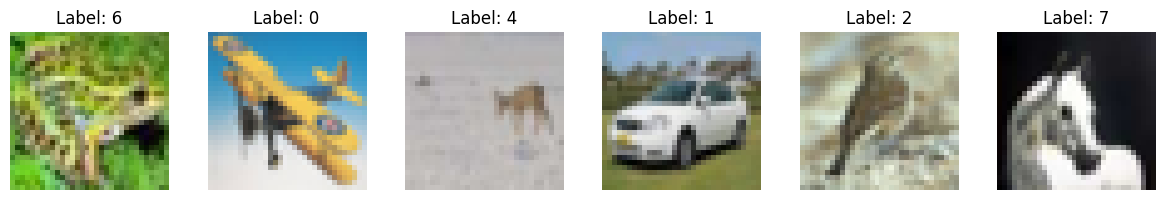

In [4]:
# Get one batch of images
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Plot a few images from the batch
num_images_to_show = 6  # choose how many images you'd like to display
fig, axes = plt.subplots(1, num_images_to_show, figsize=(12, 2))

for idx in range(num_images_to_show):
    ax = axes[idx]
    # Unnormalize the image: mapping from [-1, 1] to [0, 1]
    img = (images[idx] + 1) / 2  
    # Convert from (C, H, W) to (H, W, C) for RGB images
    img = img.permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"Label: {labels[idx].item()}")
    ax.axis('off')  # Hide axis ticks

plt.tight_layout()
plt.show()

# Forward Process

We define the linear noise scheduler, and show the forward process by adding noises to the selected images

In [5]:
# Define a scheduler – this handles the noise schedule and denoising steps
scheduler = DDPMScheduler(
    num_train_timesteps=num_train_timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear",
)

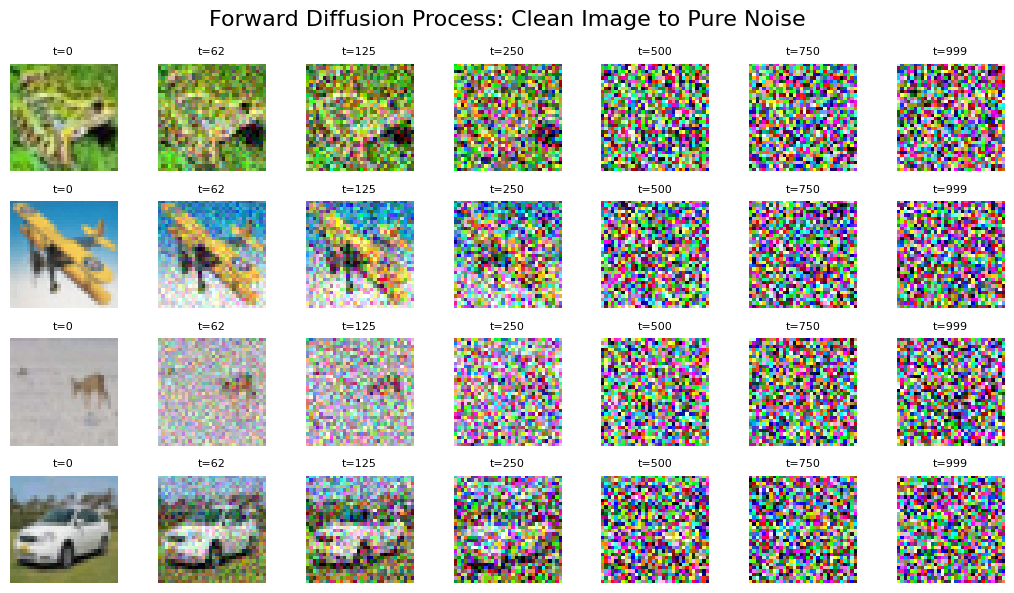

In [6]:
num_samples = 4 # Number of samples (rows) to display
samples = images[:num_samples].to(device)

# Total number of timesteps from the scheduler (e.g., 1000)
T = scheduler.config.num_train_timesteps

# Define the timesteps at which we want to display the forward process.
# These timesteps will range from 0 (clean image) to T - 1 (nearly pure noise).
timesteps_list = [0, T // 16, T // 8, T // 4, T // 2, 3 * T // 4, T - 1]
num_timesteps = len(timesteps_list)

# Create a grid of subplots: each row corresponds to one sample and each column to a timestep.
fig, axes = plt.subplots(num_samples, num_timesteps, figsize=(num_timesteps * 1.5, num_samples * 1.5))

# Loop over each sample and each selected timestep.
for i in range(num_samples):
    # Add a batch dimension so that the image shape is [1, 1, image_size, image_size]
    x0 = samples[i].unsqueeze(0)
    for j, t in enumerate(timesteps_list):
        # Generate random noise matching the shape of x0.
        noise = torch.randn_like(x0)
        # Create a tensor for the timestep. (The scheduler expects a tensor for timesteps.)
        t_tensor = torch.tensor([t], device=device)
        # Use the scheduler to add noise according to the forward diffusion process.
        x_t = scheduler.add_noise(x0, noise, t_tensor)
        
        # Unnormalize the image for visualization: original images are normalized to [-1, 1],
        # so we map them back to [0, 1] using (x + 1)/2.
        x_t_vis = (x_t.detach().cpu().squeeze() + 1) / 2
        # Convert from (C, H, W) to (H, W, C) for RGB visualization.
        x_t_vis = x_t_vis.permute(1, 2, 0)
        # Clip values to [0, 1] to ensure proper display with imshow.
        x_t_vis = torch.clamp(x_t_vis, 0, 1).numpy()
        
        # Plot the image. For MNIST, we use a grayscale colormap.
        axes[i, j].imshow(x_t_vis)
        axes[i, j].set_title(f"t={t}", fontsize=8)
        axes[i, j].axis('off')

plt.suptitle("Forward Diffusion Process: Clean Image to Pure Noise", fontsize=16)
plt.tight_layout()
plt.show()

# Backward Process

We initialize the model (noise predictors) and load the trained model

In [7]:
# -------------------- Model & Scheduler --------------------
# Using diffusers' UNet2DModel for a 1-channael image (MNIST)
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

# -------------------- Load the Checkpoint --------------------
checkpoint_path = "checkpoints-cifar/diffusion_cifar_epoch_60.pth"
state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()  # Set to evaluation mode for sampling

print("Model loaded successfully!")
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total learnable parameters: {total_params}")

Model loaded successfully!
Total learnable parameters: 113673219


In [8]:
@torch.no_grad()
def sample_with_intermediate(n=4):
    """
    Generates `n` images from pure noise using the reverse diffusion process
    and records intermediate outputs at selected timesteps.

    Args:
        n (int): Number of images to generate.

    Returns:
        intermediates (dict): A dictionary mapping timestep indices to the 
                              corresponding generated images (tensor of shape 
                              [n, 3, image_size, image_size]).
    """
    model.eval()
    # Start from pure Gaussian noise (note 3 channels for CIFAR-10)
    x = torch.randn((n, 3, image_size, image_size)).to(device)
    intermediates = {}

    # Total number of timesteps (e.g., 1000) as defined in the scheduler.
    T = scheduler.config.num_train_timesteps

    # Define the timesteps at which we want to record the intermediate outputs.
    # Here, we pick a few key steps including the first and last ones.
    save_steps = sorted(set([0, T // 32, T // 16, T // 8, T // 4, T // 2, (3 * T) // 4, T - 1]))

    # The scheduler maintains a tensor of timesteps in descending order.
    for t in scheduler.timesteps:
        # Save intermediate state if the current timestep is one of the desired steps.
        if t.item() in save_steps:
            intermediates[t.item()] = x.clone().detach().cpu()

        # Create a batch of current timestep indices (one per image).
        t_batch = torch.full((n,), t, device=device, dtype=torch.long)
        
        # Predict the noise component using the trained model.
        noise_pred = model(x, t_batch).sample
        
        # Use the scheduler to perform one reverse diffusion step.
        step_output = scheduler.step(noise_pred, t, x)
        x = step_output.prev_sample

    # Ensure the final state (timestep 0) is saved.
    intermediates[0] = x.clone().detach().cpu()

    # Optionally, clip the final images to the valid range [-1, 1]
    x = x.clamp(-1, 1)
    return intermediates

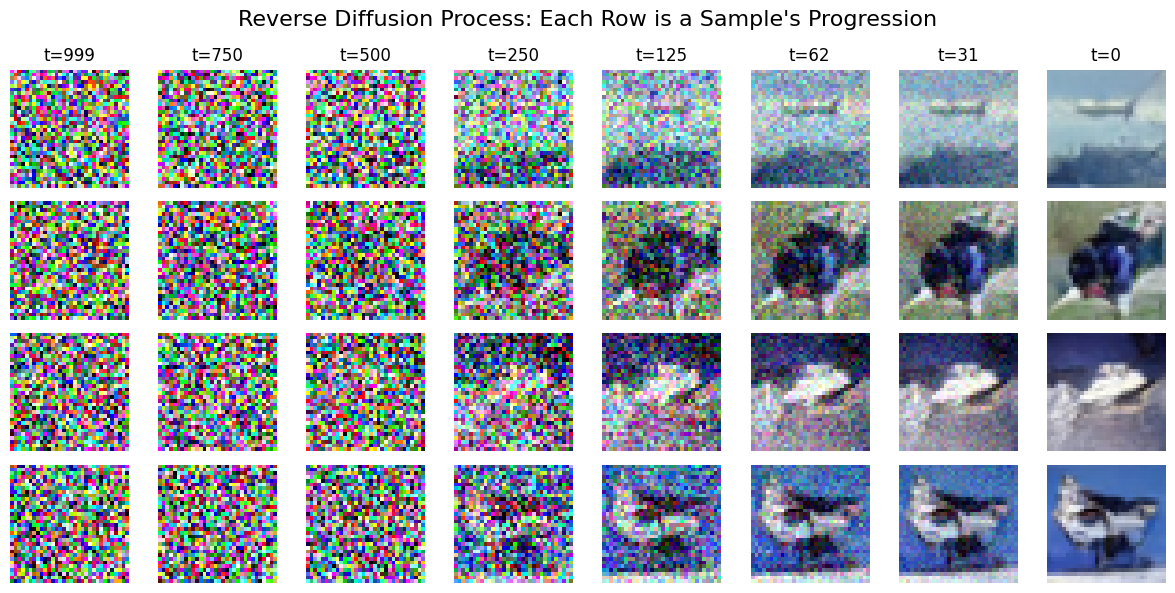

In [9]:
# Generate intermediate outputs (for example, 4 images with intermediate steps).
intermediates = sample_with_intermediate(n=4)

# Sort the intermediate timesteps in descending order.
# This means the first column corresponds to the highest timestep (pure noise),
# and the last column corresponds to t=0 (the final denoised image).
timesteps = sorted(intermediates.keys(), reverse=True)
num_steps = len(timesteps)
num_samples = 4  # 4 rows, one for each sample

# Create a grid of subplots.
fig, axes = plt.subplots(num_samples, num_steps, figsize=(num_steps * 1.5, num_samples * 1.5))

for i in range(num_samples):
    for j, t in enumerate(timesteps):
        # Get the image for sample i at timestep t.
        # Unnormalize the image: mapping from [-1, 1] to [0, 1]
        img = (intermediates[t][i] + 1) / 2
        # Clip the values to ensure they are within [0, 1]
        img = torch.clamp(img, 0, 1)
        # Convert the image from (C, H, W) to (H, W, C) for RGB visualization.
        img = img.permute(1, 2, 0).numpy()
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        # Optionally, set a title for the first row.
        if i == 0:
            axes[i, j].set_title(f"t={t}")
            
plt.suptitle("Reverse Diffusion Process: Each Row is a Sample's Progression", fontsize=16)
plt.tight_layout()
plt.show()